In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score
from sklearn.preprocessing import label_binarize
import pickle
from MVDD.MVDD import MVDD
import MVDD.MVDD_Generator as mvGen

plt.rc('font', size=12)
warnings.filterwarnings('ignore')

# Hemo

In [2]:
#Load original dataframes
hemoData = pd.read_csv('Data/Preprocessed Data/Cluster_Hemo.csv', index_col='DEIDNUM')
allScores = hemoData['Score']
death = hemoData['ScoreDeath']
rehosp = hemoData['ScoreRehosp']
readm = hemoData['ScoreReadmission']
hemoData

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
DEIDNUM,,,,,,,,,,,,,,,,,,,,,
72,88.0,2.0,1.0,25.0,24.0,42.0,24.0,30.0,36.0,2.20,...,0.666667,0.266667,0.750000,0.777778,50.0,1.166667,1,1,3,1
72,88.0,2.0,1.0,25.0,18.0,42.0,24.0,30.0,24.0,3.10,...,0.750000,0.272727,1.000000,1.000000,50.0,1.333333,1,1,3,1
81,69.0,1.0,1.0,20.0,10.0,40.0,20.0,27.0,18.0,4.52,...,0.555556,0.242857,2.000000,0.944444,45.0,1.700000,3,2,5,3
81,69.0,1.0,1.0,20.0,12.0,35.0,15.0,25.0,17.0,4.65,...,0.705882,0.571429,1.666667,2.352941,45.0,3.333333,3,2,5,3
814,58.0,1.0,1.0,NaN,3.0,51.0,19.0,30.0,18.0,4.10,...,0.166667,0.566667,10.666667,1.888889,44.0,11.333333,3,2,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98508,57.0,1.0,98.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,37.0,NaN,5,5,1,5
99302,41.0,1.0,2.0,15.0,19.0,87.0,37.0,54.0,44.0,3.90,...,0.431818,0.642857,2.631579,1.227273,13.0,2.842105,4,3,4,4
99302,41.0,1.0,2.0,15.0,11.0,70.0,28.0,44.0,28.0,5.30,...,0.392857,1.088608,3.818182,3.071429,13.0,7.818182,4,3,4,4


In [3]:
# Preprocess and create training and testing sets
hemo = hemoData.drop('Score', axis=1)
hemo = hemo.drop('ScoreDeath', axis=1)
hemo = hemo.drop('ScoreRehosp', axis=1)
hemo = hemo.drop('ScoreReadmission', axis=1)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)

xData = hemo
yData = allScores
xData.shape, yData.shape

((418, 28), (418,))

In [ ]:
mvdd= mvGen.generateTreeCrossValidation(xData=xData, yData=yData, classes=["1", "2", "3", "4", "5"], 
                                        learningCriteria='gini', maxLevels=None, minSamplesPerLeaf=1, 
                                        modelName='Test_Hemo', numFolds=5, 
                                        showIndividualROC=True)


Total edges: 48 Nonterminal Edge 23
Must have more than 7 and less than 14 OR Edges


In [ ]:
# Get Feature importance
featureDict = dict(zip(hemo.columns, mvdd.model.feature_importances_))
featureImp = pd.DataFrame.from_dict(featureDict, orient='index')
featureImp.rename(columns = {0:'Feature Importance'}, inplace = True)
featureImp = featureImp.sort_values(by=['Feature Importance'], ascending=False)
featureImp.head(10)

# Validation

In [5]:
#Validation Method
def performValidation(model, data, realScores, aucName):
    y_pred = model.predictScoreSet(data)
    
    acc = accuracy_score(realScores,y_pred)
    recall = recall_score(realScores,y_pred,average='weighted')
    f1 = f1_score(realScores,y_pred,average='weighted')
    prec = precision_score(realScores,y_pred,average='weighted')
    
    #ROC AUC Score
    y_score = label_binarize(y_pred, classes=[1,2,3,4,5])
    y_test = label_binarize(realScores, classes=[1,2,3,4,5])
    fpr, tpr, roc_auc = mvGen.getClassROC(y_test,y_score)
    
    mvGen.getAverageROCGraph(fpr, tpr, roc_auc, aucName)

    print("Accuracy:", acc)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Precision:", prec)
    
    return acc, recall, f1, prec

In [6]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/Test_Hemo')

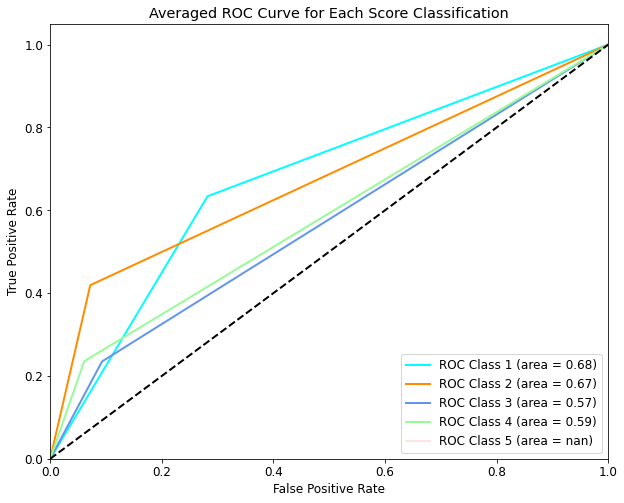

Accuracy: 0.35912622595847665
Recall: 0.35912622595847665
F1 Score: 0.42136427444249136
Precision: 0.6242418662799925


In [11]:
hemoCohort = pd.read_csv("Data Validation/ARIC/Preprocessed Data/Clustered_HemoDF_ARIC_Cohort.csv", sep=",", index_col='ID')
deathLabels = hemoCohort['ScoreDeath']

hemo = hemoCohort.drop('ScoreDeath', axis=1)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)

#get predicted scores from model
acc, recall, f1, prec = performValidation(model=testModel, data=hemo, realScores=deathLabels, aucName='HemoAricCohort')